In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('ebw_data.csv')
df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


## Описательная статистика

In [ ]:
df.shape

(72, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [ ]:
df.describe()

#Большой разброс среднего значения. Следует номрализовать данные (дополнительно это подтвержается на нижеприведённых графиках)

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [ ]:
df.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [ ]:
df.nunique()

#в связи с измерением шва в 4 проекциях было приянто решение не кодировать категориальные признаки

IW        7
IF        8
VW        5
FP        5
Depth    29
Width    25
dtype: int64

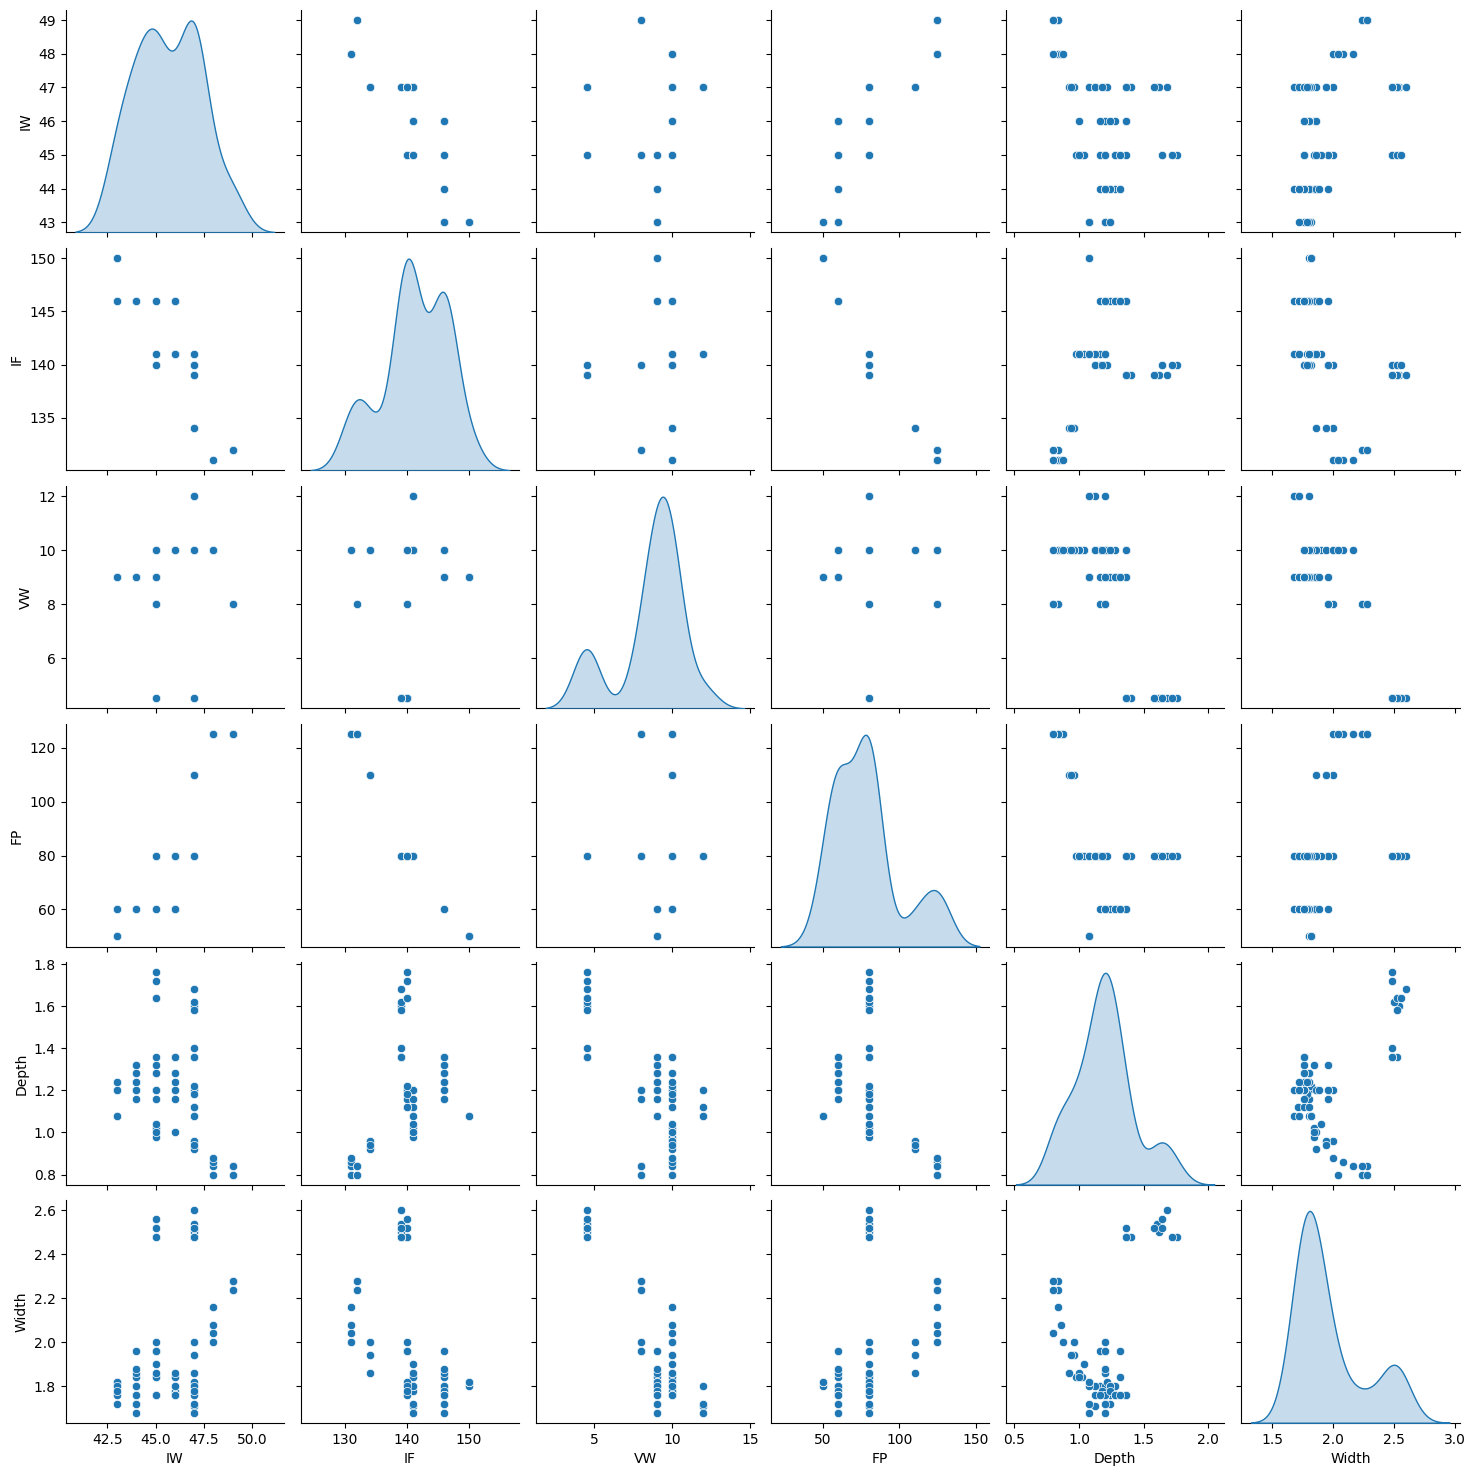

In [ ]:
sns.pairplot(df, diag_kind = 'kde')

# попарные граффики рассеивания

In [ ]:
def plot_hist(df, columns, n_rows, n_cols):

    fig=plt.figure(figsize=(15, 10))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.histplot(data=df, x=var_name, kde=True)


    plt.show()

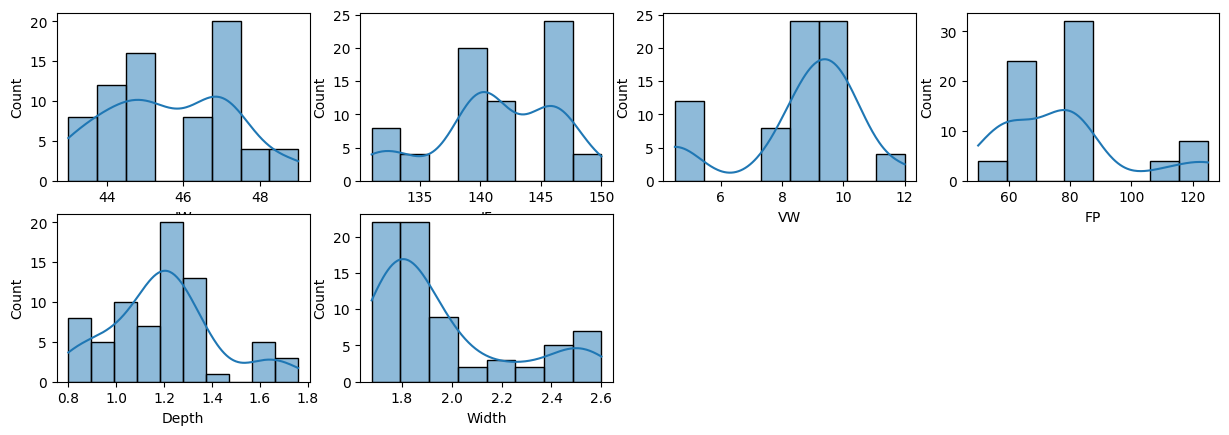

In [ ]:
plot_hist(df, df.columns, 4, 4)

Text(0.5, 1.0, 'График оценки плотности ядра')

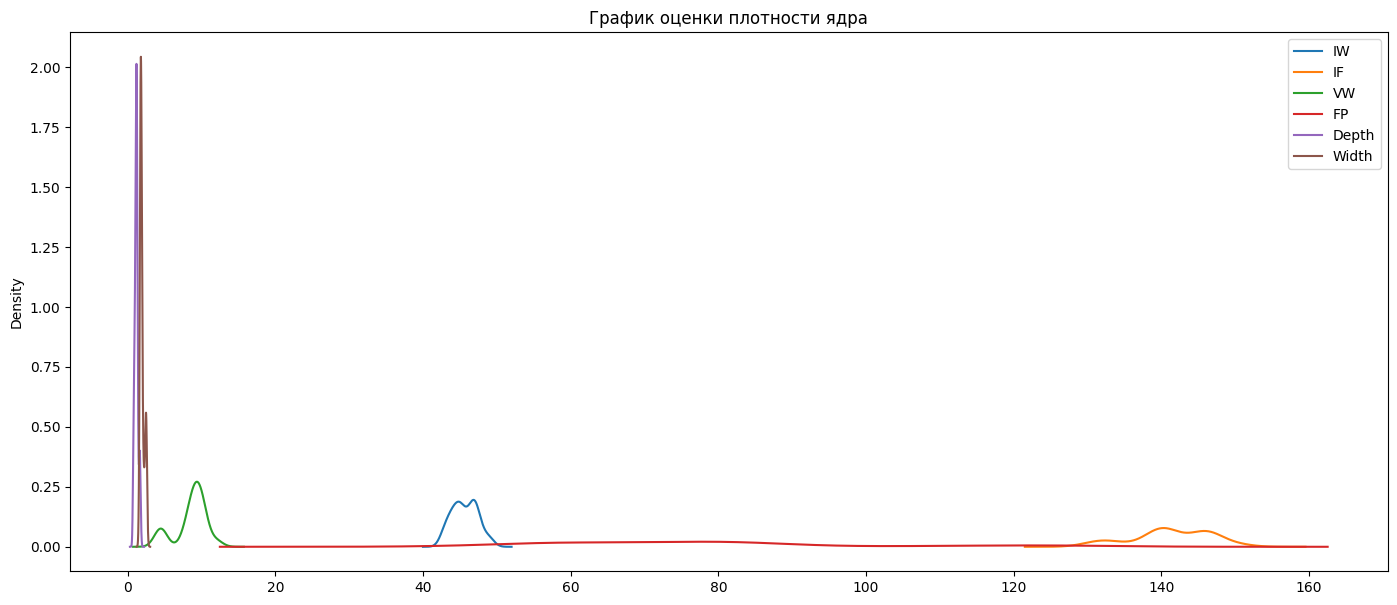

In [ ]:
fig, ax = plt.subplots(figsize=(17, 7))
df.plot(kind='kde', ax=ax)
plt.title('График оценки плотности ядра')


In [ ]:
# Из 2 вышеприведённых графиков следует, что нужно производить нормализацию значений,
# так как данные находятся в разных диапазонах.

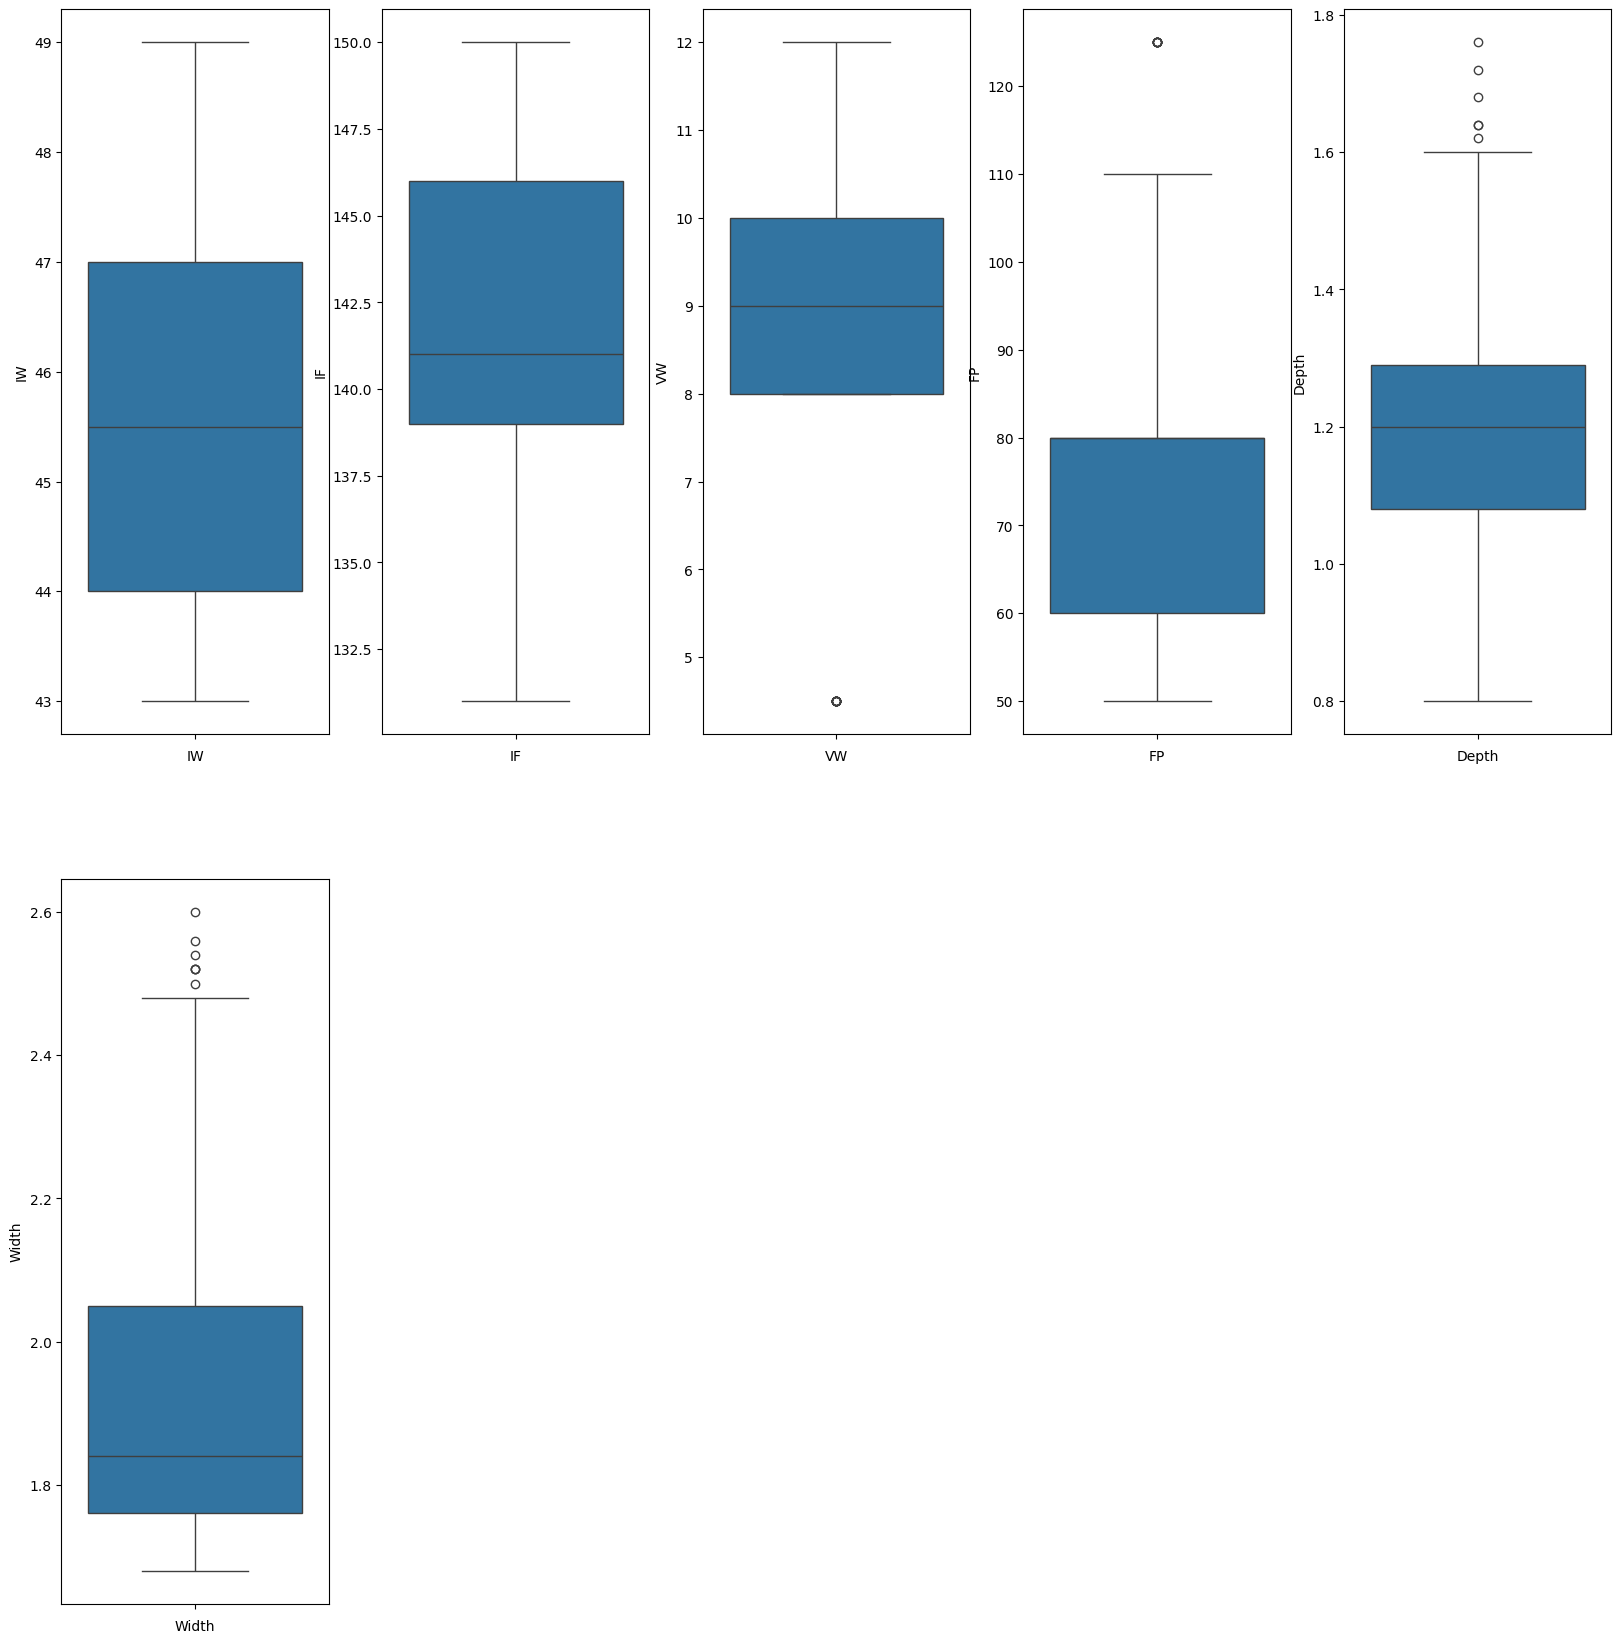

In [ ]:
n = 1 # счетчик
s = 3 # строки
c = 5 # столбцы
fig = plt.figure(figsize=(20, 32))
for i in df.columns:
    plt.subplot(s, c, n)
    plt.xlabel(i)
    sns.boxplot(y = df[i])
    n = n + 1

plt.show()

# Из графика следует, что в наборе данных есть выбросы.
# Далее осуществляется проверка отдалённости выброса относительно оснвной массы данных.
# Проверка нахождения выбросов в диапазоне проводится с помощью метода 3 сигм.

In [ ]:
sgm = 0
iqd= 0
for column in df:
    d = df.loc[:, [column]]
 # методом 3-х сигм
    zscore = (df[column] - df[column].mean()) / df[column].std()
    d['3s'] = zscore.abs() > 3
    sgm += d['3s'].sum()
print('Всего выбросов',sgm)

Всего выбросов 0


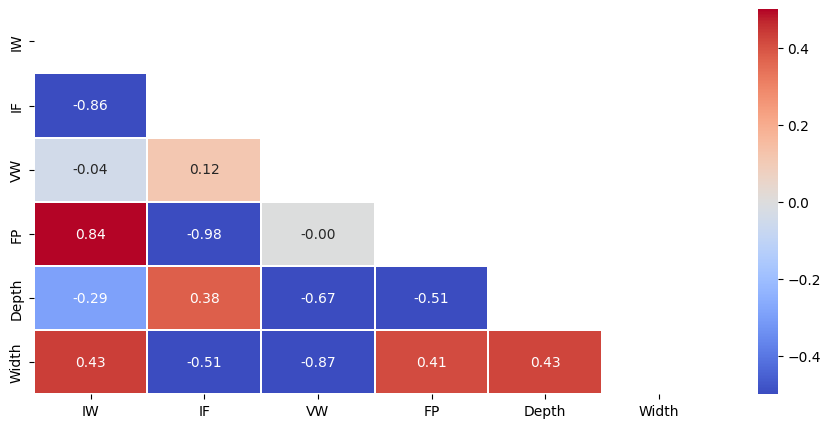

In [ ]:
matrix = np.triu(df.corr())
fig = plt.subplots(figsize=(11, 5))
sns.heatmap(df.corr(), vmin=-0.5, vmax=0.5,  annot=True,fmt='.2f',cmap='coolwarm',  linewidths = 0.1,mask=matrix)
plt.show()

#Наиболее значимая обратная линейная зависимость у параметров ширины и глубины наблюдается с скоростью сварки (VW)

# Нормализация

In [ ]:
col = df.columns
minmax = MinMaxScaler()
di = minmax.fit_transform(np.array(df))
dn = pd.DataFrame(data = di, columns = col)
dn.head()

,IW,IF,VW,FP,Depth,Width
0,0.666667,0.421053,0.0,0.4,0.833333,0.934783
1,0.666667,0.421053,0.0,0.4,0.854167,0.891304
2,0.666667,0.421053,0.0,0.4,0.916667,1.000000
3,0.666667,0.421053,0.0,0.4,0.812500,0.913043
4,0.333333,0.473684,0.0,0.4,1.000000,0.869565


In [ ]:
dn.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.444444,0.543860,0.551852,0.377778,0.412037,0.315670
std,0.279727,0.270830,0.274810,0.286580,0.234460,0.303304
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.421053,0.466667,0.133333,0.291667,0.086957
50%,0.416667,0.526316,0.600000,0.400000,0.416667,0.173913
75%,0.666667,0.789474,0.733333,0.400000,0.510417,0.402174
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'График оценки плотности ядра после нормализации')

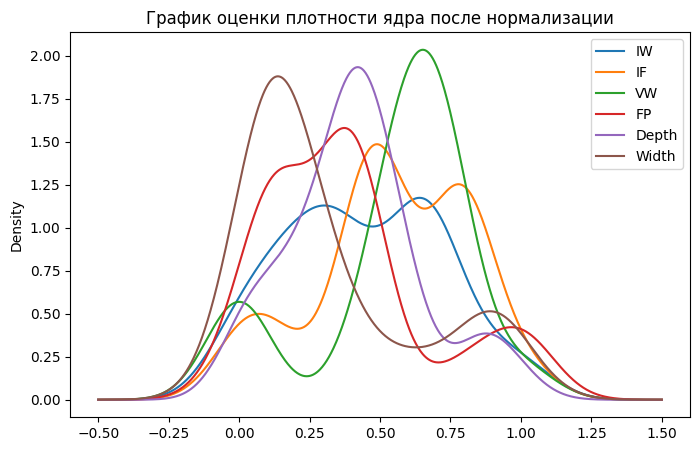

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
dn.plot(kind='kde', ax=ax)
plt.title('График оценки плотности ядра после нормализации')

## Разделение выборок

In [ ]:
dn.head()

,IW,IF,VW,FP,Depth,Width
0,0.666667,0.421053,0.0,0.4,0.833333,0.934783
1,0.666667,0.421053,0.0,0.4,0.854167,0.891304
2,0.666667,0.421053,0.0,0.4,0.916667,1.000000
3,0.666667,0.421053,0.0,0.4,0.812500,0.913043
4,0.333333,0.473684,0.0,0.4,1.000000,0.869565


In [ ]:
test_depth = dn['Depth']
t_d = dn.loc[:,dn.columns != 'Depth']
train_depth = t_d.loc[:,t_d.columns != 'Width']

X_train_depth, X_test_depth, y_train_depth, y_test_depth = train_test_split(train_depth, test_depth , test_size=0.25, random_state=42)

In [ ]:
test_width = dn['Width']
t_w = dn.loc[:,dn.columns != 'Depth']
train_width = t_w.loc[:,t_d.columns != 'Width']

X_train_width, X_test_width, y_train_width, y_test_width = train_test_split(train_width, test_width , test_size=0.25, random_state=42)

In [ ]:
# функция для отрисовки графиков действительных и предсказанных значений

def actual_and_predicted_plot(orig, predict, var, model_name):
    plt.figure(figsize=(17,5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(orig, label='Тест')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

# 1) Алгоритм k - ближайших соседей

In [ ]:
knr_model = KNeighborsRegressor()

## 1.1) Для глубины

In [ ]:
neigh_params = {'n_neighbors' : range(1, 101, 1), 'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

GSCV_neigh_d = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=10)
GSCV_neigh_d.fit(X_train_depth, y_train_depth)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 101),
                         'weights': ['uniform', 'distance']})

In [ ]:
neigh_d = GSCV_neigh_d.best_estimator_
neigh_d

KNeighborsRegressor(n_neighbors=2, weights='distance')

In [ ]:
MSE_knn_d = mean_squared_error(y_test_depth, neigh_d.predict(X_test_depth))

R2_knn_d = r2_score(y_test_depth, neigh_d.predict(X_test_depth))

print(f'MSE_knn_d = {MSE_knn_d}\nR2_knn_d = {R2_knn_d}')

MSE_knn_d = 0.006757571373456793
R2_knn_d = 0.8735872697656935


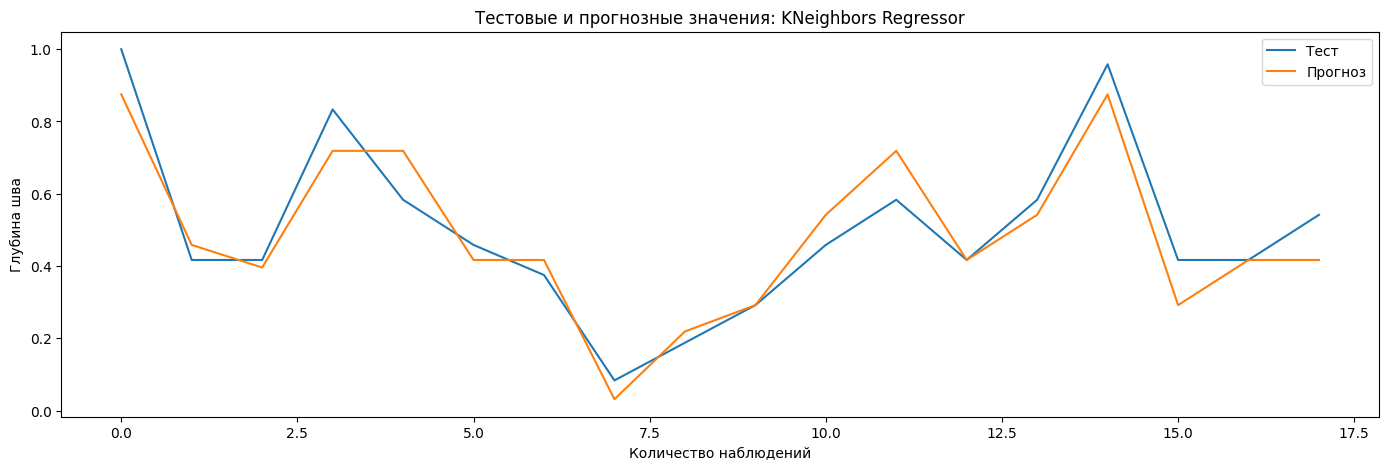

In [ ]:
actual_and_predicted_plot(y_test_depth.values,
neigh_d.predict(X_test_depth), 'Глубина шва', 'KNeighbors Regressor')

## 1.2) Для ширины

In [ ]:
neigh_params = {'n_neighbors' : range(1, 101, 1), 'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

GSCV_neigh_w = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=10)
GSCV_neigh_w.fit(X_train_width, y_train_width)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 101),
                         'weights': ['uniform', 'distance']})

In [ ]:
neigh_w = GSCV_neigh_w.best_estimator_
neigh_w

KNeighborsRegressor(n_neighbors=1)

In [ ]:
MSE_knn_w = mean_squared_error(y_test_width, neigh_d.predict(X_test_width))

R2_knn_w = r2_score(y_test_width, neigh_d.predict(X_test_width))

print(f'MSE_knn_w = {MSE_knn_w}\nR2_knn_w = {R2_knn_w}')

MSE_knn_w = 0.06418926464517836
R2_knn_w = 0.41885595493562233


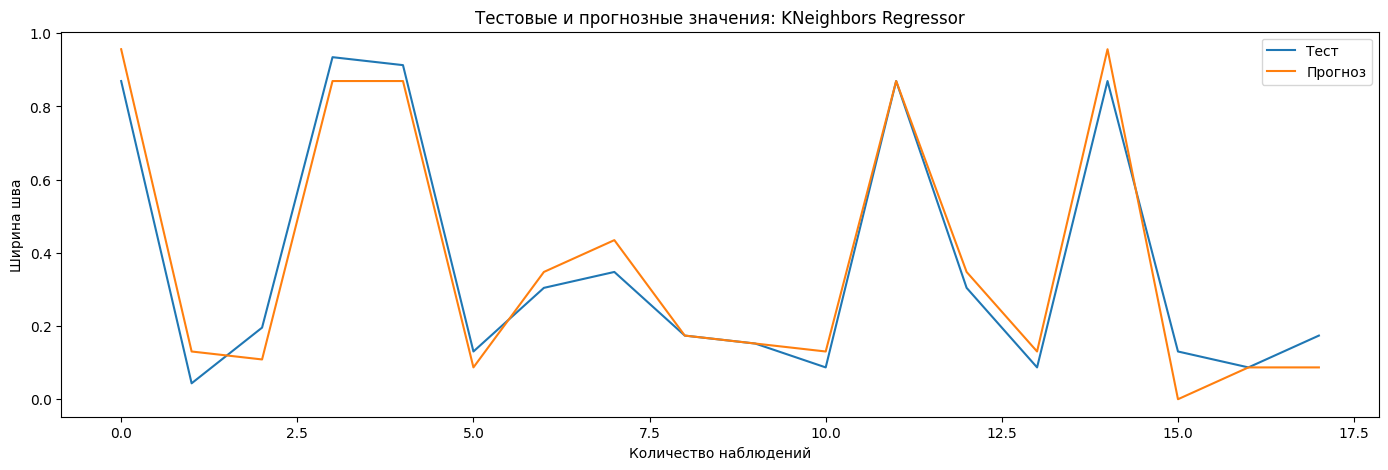

In [ ]:
actual_and_predicted_plot(y_test_width.values,
neigh_w.predict(X_test_width), 'Ширина шва', 'KNeighbors Regressor')

# 2) Алгоритм случайный лес

In [ ]:
rf_model = RandomForestRegressor(random_state=42)


## 2.1) Для глубины

In [ ]:
rf_model_params = {
 'n_estimators' : range(1, 100, 5),
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth' : range(1, 5, 1),
 'criterion':['friedman_mse']}
GSCV_rf_model_d = GridSearchCV(rf_model, rf_model_params, cv=5, verbose=0)
GSCV_rf_model_d.fit(X_train_depth, y_train_depth)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['friedman_mse'],
                         'max_depth': range(1, 5),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(1, 100, 5)})

In [ ]:
rf_model_d = GSCV_rf_model_d.best_estimator_
rf_model_d

RandomForestRegressor(criterion='friedman_mse', max_depth=4,
                      max_features='auto', n_estimators=71, random_state=42)

In [ ]:
MSE_rf_d = mean_squared_error(y_test_depth, rf_model_d.predict(X_test_depth))
R2_rf_d = r2_score(y_test_depth, rf_model_d.predict(X_test_depth))
print(f'MSE_rf_d = {MSE_rf_d}\nR2_rf_d = {R2_rf_d}')

MSE_rf_d = 0.00830214454778658
R2_rf_d = 0.8446932039507709


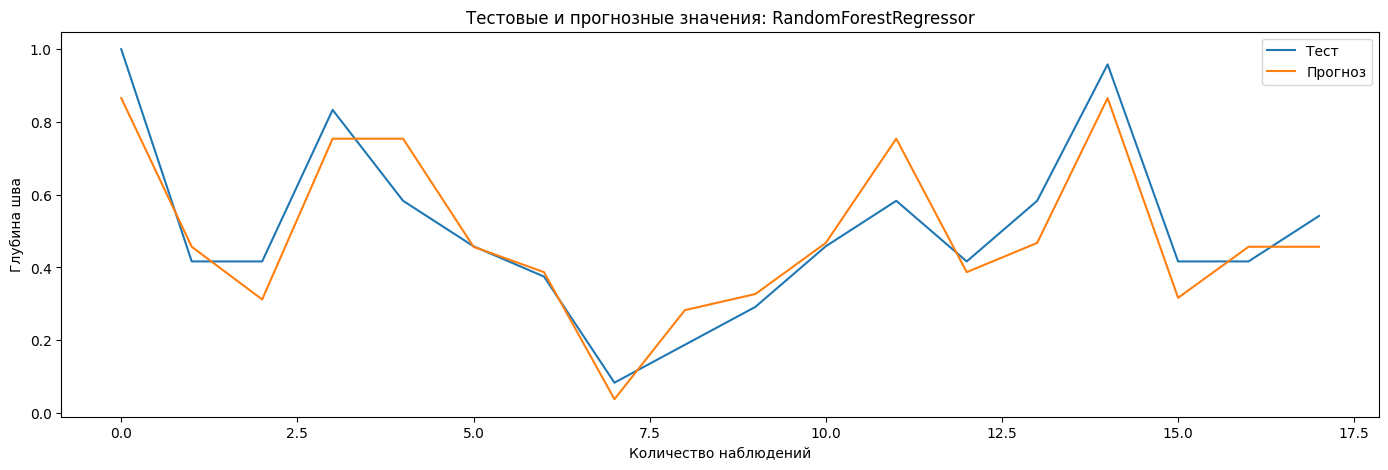

In [ ]:
actual_and_predicted_plot(y_test_depth.values,
rf_model_d.predict(X_test_depth), 'Глубина шва', 'RandomForestRegressor')

## 2.2) Для ширины

In [ ]:
rf_model_params = {
 'n_estimators' : range(1, 100, 5),
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth' : range(1, 5, 1),
 'criterion':['friedman_mse']}
GSCV_rf_model_w = GridSearchCV(rf_model, rf_model_params, cv=5, verbose=0)
GSCV_rf_model_w.fit(X_train_width, y_train_width)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['friedman_mse'],
                         'max_depth': range(1, 5),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(1, 100, 5)})

In [ ]:
rf_model_w = GSCV_rf_model_w.best_estimator_
rf_model_w

RandomForestRegressor(criterion='friedman_mse', max_depth=4,
                      max_features='auto', n_estimators=71, random_state=42)

In [ ]:
MSE_rf_w = mean_squared_error(y_test_width, rf_model_w.predict(X_test_width))
R2_rf_w = r2_score(y_test_width, rf_model_w.predict(X_test_width))
print(f'MSE_rf_w = {MSE_rf_w}\nR2_rf_w = {R2_rf_w}')

MSE_rf_w = 0.0030498581596963958
R2_rf_w = 0.9723877985268102


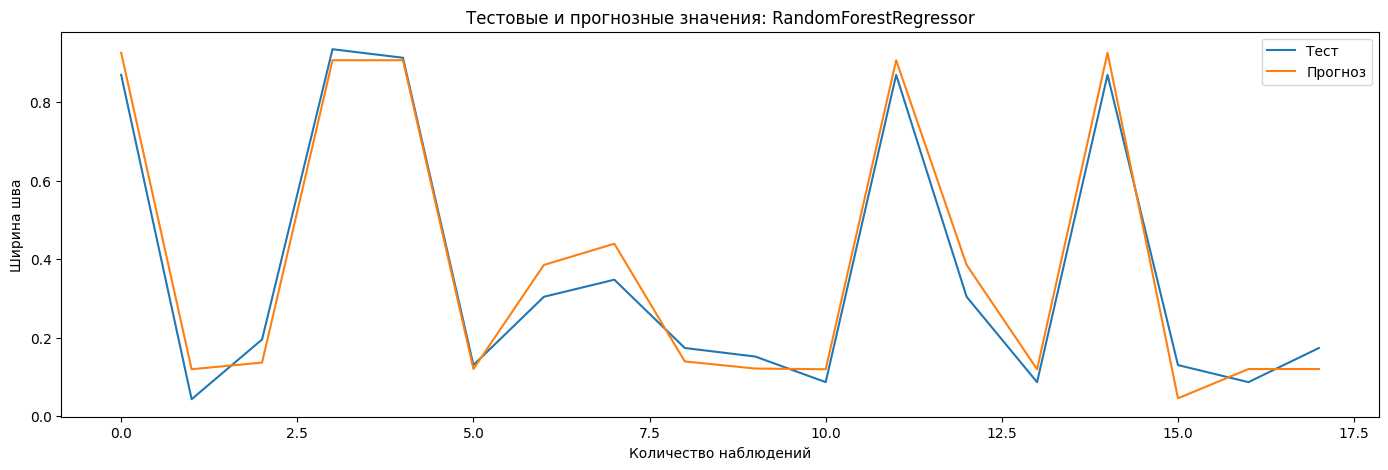

In [ ]:
actual_and_predicted_plot(y_test_width.values,
rf_model_w.predict(X_test_width), 'Ширина шва', 'RandomForestRegressor')

# 3) Нейронная сеть

In [ ]:
# Построена 1 последовательная модель нейронной сети для прараметров ширины и глубины с двумя выходами.

In [ ]:
model = Sequential()

#### 3.1)Разбиение на тестовые и обучающие выборки


In [ ]:
#Выводится размерность выборок для контроля корректности разбиения
# Данные берутся из нормализованного в предыдущих шагах датасета (dn)

In [ ]:
X = dn[['IW', 'IF', 'VW', 'FP']]

In [ ]:
y = dn[['Depth', 'Width']]

In [ ]:
X.shape,y.shape

((72, 4), (72, 2))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(50, 4) (22, 4)
(50, 2) (22, 2)


#### 3.2) Добавление слоёвб компиляция и обучение нейросети

In [ ]:
model.add(Dense(128, input_dim = 4, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(2, activation="relu"))

In [ ]:
model.compile(optimizer = 'adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 28050 (109.57 KB)
Trainable params: 28050 

In [ ]:
model_hist = model.fit(X_train, y_train, epochs=100, verbose=1,validation_split = 0.2)

Epoch 1/100
2/2 [==============================] - 2s 245ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 2/100
2/2 [==============================] - 0s 53ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 3/100
2/2 [==============================] - 0s 54ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 5/100
2/2 [==============================] - 0s 55ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 6/100
2/2 [==============================] - 0s 36ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 8/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 9/100
2/2 [==============================] - 0s 35ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 10/100
2/2 [==============================] - 0s 34ms/step - loss: 0.1786 - val_loss: 0.2306
Epoch 11/100
2/2 [

#### 3.3) Оценка модели

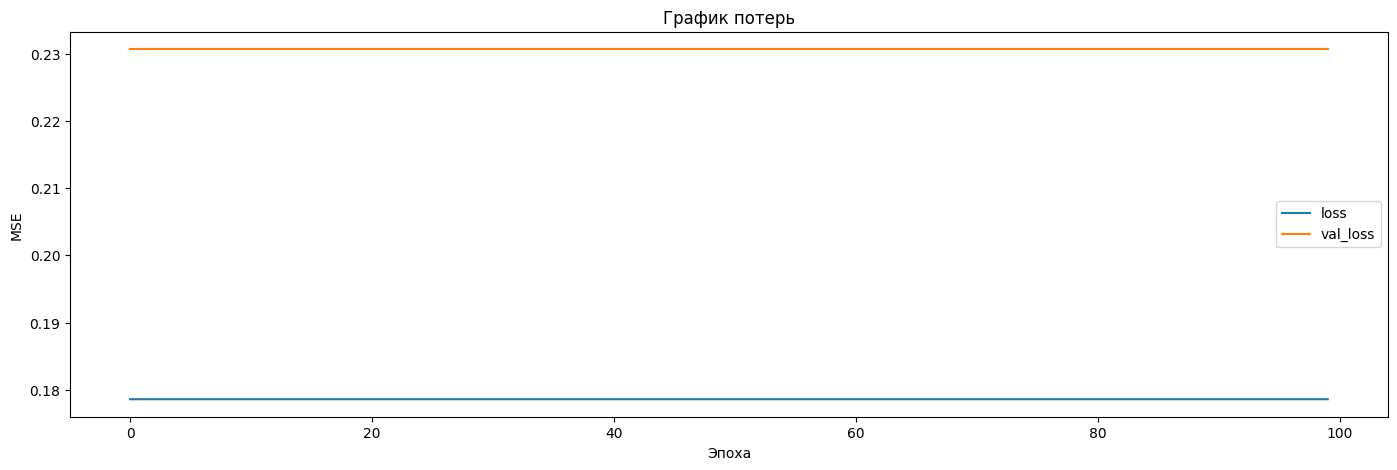

In [ ]:
def model_loss_plot(model_hist):
    plt.figure(figsize=(17,5))
    plt.plot(model_hist.history['loss'])
    plt.plot(model_hist.history['val_loss'])
    plt.title('График потерь')
    plt.ylabel('MSE')
    plt.xlabel('Эпоха')
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()
model_loss_plot(model_hist)

#### 3.3.1) Для глубины и ширины

1/1 [==============================] - 0s 134ms/step


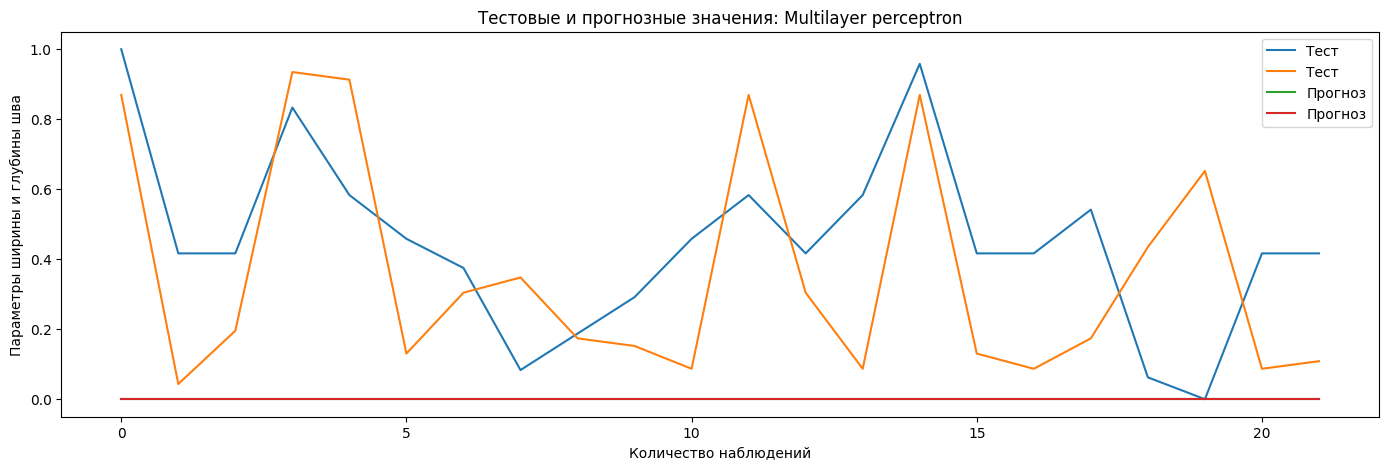

In [ ]:
actual_and_predicted_plot(y_test.values, model.predict(X_test.values),'Параметры ширины и глубины шва', 'Multilayer perceptron')


In [ ]:
MSE = mean_squared_error(y_test, model.predict(X_test.values))
R2 = r2_score(y_test, model.predict(X_test.values))
print(f'MSE = {MSE}\n R2 = {R2}')

1/1 [==============================] - 0s 28ms/step
MSE = 0.2484229478743006
 R2 = -2.286774516821883


#### 3.3.2) Для глубины

1/1 [==============================] - 0s 29ms/step


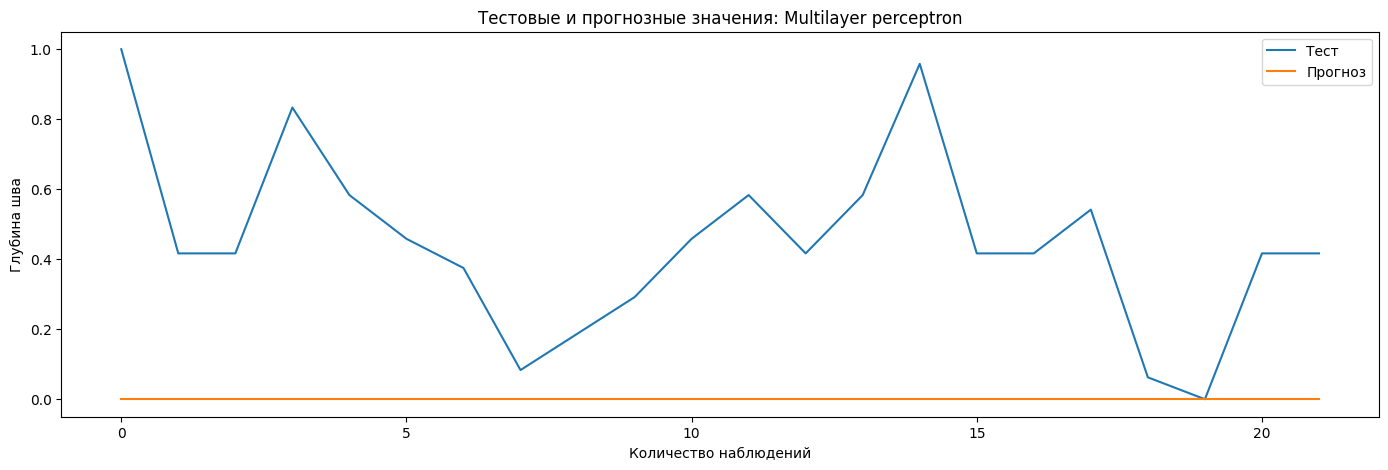

In [ ]:
actual_and_predicted_plot(y_test.values[:,0], model.predict(X_test.values)[:,0],'Глубина шва', 'Multilayer perceptron')


In [ ]:
MSE_n_d = mean_squared_error(y_test.iloc[:,0], model.predict(X_test.values)[:,0])
R2_n_d = r2_score(y_test.iloc[:,0], model.predict(X_test.values)[:,0])
print(f'MSE_n_d = {MSE_n_d}\n R2_n_d = {R2_n_d}')

1/1 [==============================] - 0s 26ms/step
MSE_n_d = 0.2651909722222221
 R2_n_d = -3.2766818996934095


#### 3.3.3) Для ширины

1/1 [==============================] - 0s 22ms/step


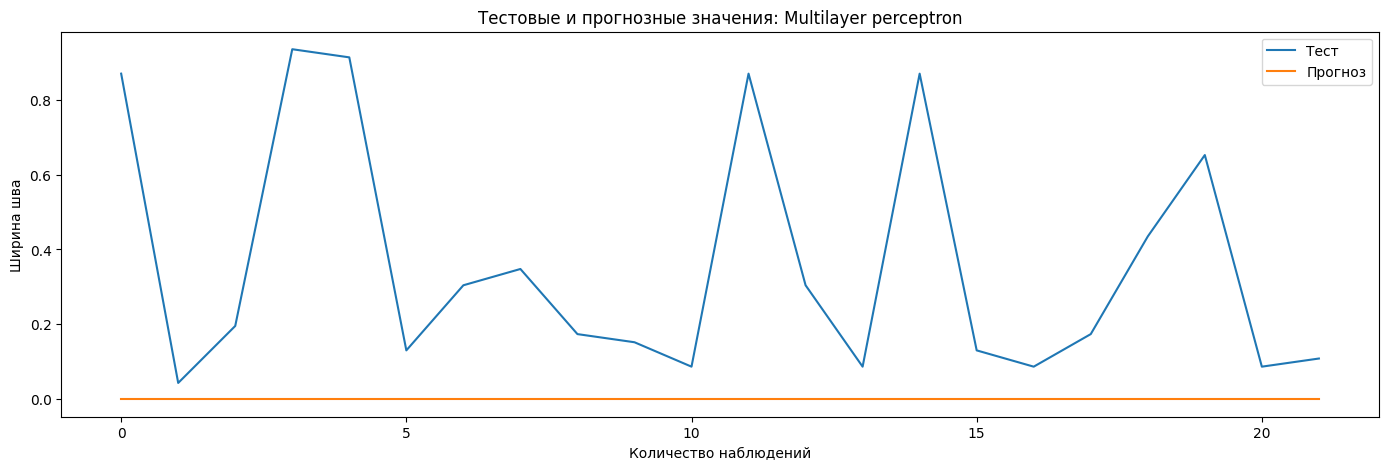

In [ ]:
actual_and_predicted_plot(y_test.values[:,1], model.predict(X_test.values)[:,1],'Ширина шва', 'Multilayer perceptron')

In [ ]:
MSE_n_w = mean_squared_error(y_test.iloc[:,1], model.predict(X_test.values)[:,1])
R2_n_w = r2_score(y_test.iloc[:,1], model.predict(X_test.values)[:,1])
print(f'MSE_n_w = {MSE_n_w}\n R2_n_w = {R2_n_w}')

1/1 [==============================] - 0s 21ms/step
MSE_n_w = 0.231654923526379
 R2_n_w = -1.2968671339503555
